In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os
from scipy.stats import sem
import matplotlib.cm as cm

In [2]:
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

# Helper functions

In [4]:
from sklearn.metrics import auc

In [6]:
def plot(
    df, plot_key, plot_ep, figsize=(6.4*0.75, 4.8*0.75),
    fnames=None, figname=None, labels=None,
    smooth_plot=True, smooth_plot_n=2, colors=None,
    legend_title=None, ylim=None, plot_title=None, show_legend=True,
    plot_auc=False, ylabel='Avg Episode Score', xlim=None):
    
    fig, ax = plt.subplots(figsize=figsize)
    zs = np.sort(np.unique(df['z']))
    episode = np.sort(np.unique(df['episode']))
    if fnames is None:
        fnames = np.unique(df['model'])
    for fname_idx, fname in enumerate(fnames):
        line = []
        shading_width = []
        shading_lower = []
        shading_upper = []
        for z in zs:
            df_subset = df[(df['model']==fname) & (df['z']==z)]
            if plot_auc:
                aucs = []
                for file in np.unique(df_subset['file']):
                    df_file_subset = df_subset[df_subset['file']==file]
                    episodes = np.array(df_file_subset['episode'])
                    vals = np.array(df_file_subset[plot_key])
                    aucs.append(auc(episodes, vals)/episodes.max())
                auc_mean = np.mean(aucs)
                auc_sem = sem(aucs)
                line.append(auc_mean)
                shading_width.append(auc_sem)
            else:
                means = []
                sems = []
                val_len = 0
                for ep in episode:
                    vals = df_subset[df_subset['episode']==ep]
                    vals = vals[plot_key]
                    means.append(np.mean(vals))
                    sems.append(sem(vals))
                    if ep == plot_ep:
                        val_len = len(vals)
                means = np.array(means)
                sems = np.array(sems)
                if z == 5:
                    print(fname)
                    print(f'Mean: {means[plot_ep]}, SEM: {sems[plot_ep]} for {val_len} vals')
                line.append(means[plot_ep])
                shading_width.append(sems[plot_ep])
        if smooth_plot:
            _line = smooth(zs, line, smooth_plot_n)
            _shading_width = smooth(zs, shading_width, smooth_plot_n)
            line = np.array(_line)
            shading_lower = line - _shading_width
            shading_upper = line + _shading_width
        x_axis = zs
        if colors is not None:
            color = colors[fname_idx]
        else:
            color = None
        if labels != None:
            label = fname_labels[fname_idx]
        else:
            label = fname
        ax.plot(x_axis, line, label=label, color=color, alpha=0.8)
        ax.fill_between(x_axis, shading_lower, shading_upper, alpha=0.2,color=color)
    plt.xlabel('Latent Dimensions')
    if show_legend:
        plt.legend(title=legend_title, fontsize=12, title_fontsize=12)
    if ylabel != None:
        plt.ylabel(ylabel)
    if ylim != None:
        plt.ylim(ylim[0], ylim[1])
    if xlim != None:
        plt.xlim(xlim[0], xlim[1])
    if plot_title != None:
        plt.title(plot_title)
    plt.xlabel('Latent Size')
    plt.tight_layout()
    if figname != None:
        plt.savefig(figname+'.png', dpi=300)
    plt.show()

In [7]:
def smooth(xs, ys, n=3):
    vals = np.copy(ys)
    smoothed = np.convolve(ys, np.ones(n)/n, mode='same')
    vals[1:-1] = smoothed[1:-1]
    return vals

In [8]:
def get_df(base, zs, net_yaml):
    data = {
        'valid_score': [], 'valid_steps':[], 'dims': [],
        'episode': [], 'model': [], 'z': [], 'step': [], 'file': []}
    for z in zs:
        task_dir = f'{base}_{net_yaml}_dim{z}'
        task_dir = f'{engram_dir}pickles/{task_dir}/'
        if not os.path.exists(task_dir): continue
        for pickle_file in os.listdir(task_dir):
            if not pickle_file.endswith('.p'): continue
            pickle_file = f'{task_dir}{pickle_file}'
            with open(pickle_file, 'rb') as f:
                results = pickle.load(f)
            valid_score = results['valid_score']
            valid_steps = results['valid_steps_per_ep']
            episode = results['episode']
            model = results['model']
            step = results['step']
            for i in range(len(valid_score)):
                if valid_score[i] == None: continue
                data['valid_score'].append(valid_score[i])
                data['valid_steps'].append(valid_steps[i])
                data['dims'].append(z)
                data['episode'].append(episode[i])
                _model = model[i].split(base+'_')[-1]
                data['model'].append(_model)
                data['z'].append(z)
                data['step'].append(step[i])
                data['file'].append(pickle_file)
    df = pd.DataFrame(data)
    return df

# Initial Gridworld Experiments

In [35]:
zs = np.arange(2, 13)

In [36]:
task_df = get_df('new_gridworld8x8_shuffobs', zs, 'dm')

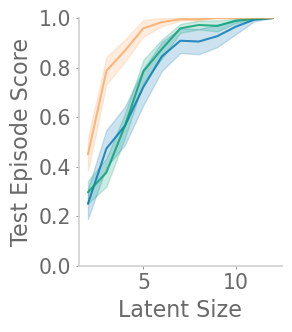

In [39]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 600, figsize=(6.4*0.5, 4.8*0.75),
    fnames=['mf0', 'entro0', 'g0_-2_entro-1'],
    smooth_plot=True, smooth_plot_n=2,
    figname='gridworld6x6_taskA_early',
    colors=['C0', 'C2', colors(c_steps[0])],
    show_legend=False,
    plot_title='', ylim=(0,1), ylabel='Test Episode Score'
    )

# Transfer Experiments with $\gamma$ (Task B)

In [16]:
zs = np.arange(2, 22)

In [17]:
task_df = get_df('frozentransfer_new_gridworld8x8_shuffobs', zs, 'dm_large_q')

In [18]:
np.unique(task_df['model'])

array(['entro2', 'g0.25_-2_entro0', 'g0.5_-2_entro0', 'g0.8_-4_entro0',
       'g0_-2_entro-1', 'mf0'], dtype=object)

In [19]:
def smooth(xs, ys, n=3):
    vals = np.copy(ys)
    smoothed = np.convolve(ys, np.ones(n)/n, mode='same')
    return smoothed

mf
Mean: nan, SEM: nan for 0 vals
entro
Mean: nan, SEM: nan for 0 vals
g0_-2_entro-1
Mean: 0.5766666666666668, SEM: 0.06300580767489838 for 30 vals
g0.25_-2_entro0
Mean: 0.7433333333333333, SEM: 0.05543627040691276 for 30 vals
g0.5_-2_entro0
Mean: 0.7166666666666666, SEM: 0.06731011321485182 for 30 vals
g0.8_-4_entro0
Mean: 0.6533333333333334, SEM: 0.06153838785730926 for 30 vals


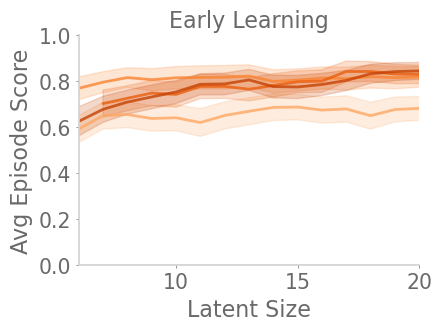

In [20]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 100, figsize=(6.4*0.75, 4.8*0.75),
    fnames=['mf', 'entro', 'g0_-2_entro-1', 'g0.25_-2_entro0', 'g0.5_-2_entro0', 'g0.8_-4_entro0'],
    show_legend=False,
    smooth_plot=True, smooth_plot_n=4, figname='gridworld6x6_taskA_early',
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning', ylim=(0,1), ylabel='Avg Episode Score', xlim=[6,20]
    )

mf
Mean: nan, SEM: nan for 0 vals
entro
Mean: nan, SEM: nan for 0 vals
g0_-2_entro-1
Mean: 0.8833333333333333, SEM: 0.04938316836744745 for 30 vals
g0.25_-2_entro0
Mean: 0.9333333333333333, SEM: 0.03468522933612544 for 30 vals
g0.5_-2_entro0
Mean: 0.85, SEM: 0.06060044383586186 for 30 vals
g0.8_-4_entro0
Mean: 0.87, SEM: 0.04501596140936229 for 30 vals


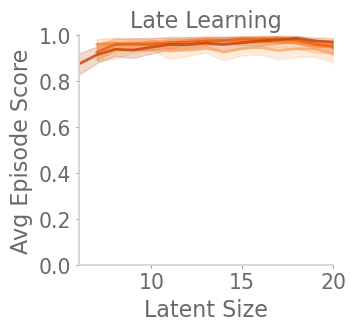

In [15]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 600, figsize=(6.4*0.6, 4.8*0.75),
    fnames=['mf', 'entro', 'g0_-2_entro-1', 'g0.25_-2_entro0', 'g0.5_-2_entro0', 'g0.8_-4_entro0'],
    show_legend=False,
    smooth_plot=True, smooth_plot_n=4, figname='gridworld6x6_taskA_early',
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning', ylim=(0,1), ylabel='Avg Episode Score', xlim=[6,20]
    )

# Transfer Experiments with $\gamma$ (Task A)

In [8]:
zs = np.arange(2, 22)

In [9]:
task_df = get_df('new_gridworld8x8_shuffobs', zs, 'dm_large_q')

mf
Mean: nan, SEM: nan for 0 vals
entro
Mean: nan, SEM: nan for 0 vals
g0_-2_entro-1
Mean: 0.92, SEM: 0.02218003658672604 for 30 vals
g0.25_-2_entro0
Mean: 0.8166666666666665, SEM: 0.04343930455332622 for 30 vals
g0.5_-2_entro0
Mean: 0.7133333333333333, SEM: 0.055238944560595846 for 30 vals
g0.8_-4_entro0
Mean: 0.74, SEM: 0.04638668060910411 for 30 vals


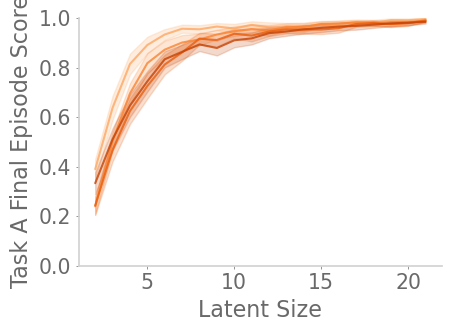

In [16]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 200, show_legend=False,
    fnames=['mf', 'entro', 'g0_-2_entro-1', 'g0.25_-2_entro0', 'g0.5_-2_entro0', 'g0.8_-4_entro0'],
    smooth_plot=True, smooth_plot_n=3, figname='gridworld6x6_taskA_early',
    colors=['C0', 'C2']+[colors(i) for i in c_steps],
    plot_title='', ylim=(0,1), ylabel='Task A Final Episode Score'
    )

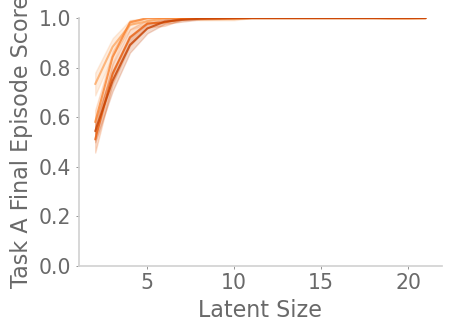

In [11]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 600, show_legend=False,
    fnames=['mf', 'entro', 'g0_-2_entro-1', 'g0.25_-2_entro0', 'g0.5_-2_entro0', 'g0.8_-4_entro0'],
    smooth_plot=True, smooth_plot_n=3, figname='gridworld6x6_taskA_early',
    colors=['C0', 'C2']+[colors(i) for i in c_steps],
    plot_title='', ylim=(0,1), ylabel='Task A Final Episode Score'
    )

# Effect of Large Q

In [28]:
zs = np.arange(2, 22)

In [29]:
task_df = get_df('new_gridworld8x8_shuffobs', zs, 'dm_large_q')

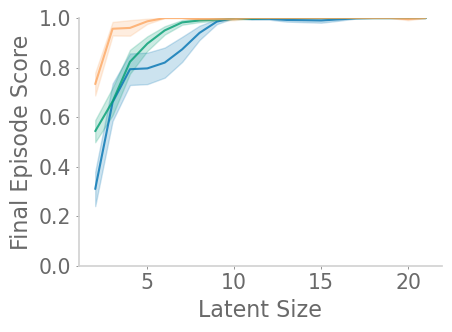

In [30]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 600, show_legend=False,
    fnames=['mf0', 'entro2', 'g0_-2_entro-1'], 
    smooth_plot=True, smooth_plot_n=3, figname='',
    colors=['C0', 'C2', colors(c_steps[0])],
    plot_title='', ylim=(0,1), ylabel='Final Episode Score'
    )

# Effect of Large Encoder

In [31]:
zs = np.arange(2, 22)

In [32]:
task_df = get_df('new_gridworld8x8_shuffobs', zs, 'dm_large_encoder')

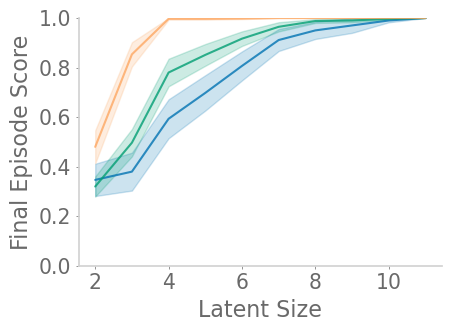

In [33]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 600, show_legend=False,
    fnames=['mf1', 'entro0', 'g0_-2_entro-1'],
    smooth_plot=True, smooth_plot_n=3, figname='',
    colors=['C0', 'C2', colors(c_steps[0])],
    plot_title='', ylim=(0,1), ylabel='Final Episode Score'
    )